# License

    Jupyter notebook for accessing CUDA
    Copyright (C) 2018 Andre.Brodtkorb@ifi.uio.no, changed in October by André Brodtkorb

    This program is free software: you can redistribute it and/or modify
    it under the terms of the GNU General Public License as published by
    the Free Software Foundation, either version 3 of the License, or
    (at your option) any later version.

    This program is distributed in the hope that it will be useful,
    but WITHOUT ANY WARRANTY; without even the implied warranty of
    MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
    GNU General Public License for more details.

    You should have received a copy of the GNU General Public License
    along with this program.  If not, see <http://www.gnu.org/licenses/>.

In [11]:
#Lets have matplotlib "inline"
%matplotlib inline

#Import packages we need
import numpy as np
import pycuda.compiler as cuda_compiler
from pycuda.gpuarray import GPUArray
import pycuda.driver as cuda_driver

from matplotlib import pyplot as plt

import pytest
from ipytest import run_pytest, clean_tests
from Timer import Timer
import IPythonMagic
import logging

In [12]:
%setup_logging
%cuda_context_handler context

Global logger already initialized!
Registering context in user workspace
Context already registered! Ignoring


In [44]:
cuda_kernel = """
__global__ void matrixVectorKernel(float* c, float* A, float* b, int a_rows, int a_cols) {
    unsigned int j = blockIdx.x*blockDim.x + threadIdx.x;
    
    //Out of bounds check
    if (j > a_rows) {
        return;
    }
    
    //Compute inner product of row of A with column of B
    float sum = 0.0f;
    for (int i=0; i<a_cols; ++i) {
        unsigned int k = j*a_cols + i;
        sum += A[k] * b[i];
    }
    
    //Write to global memory
    c[j] = sum;
}
"""
module = cuda_compiler.SourceModule(cuda_kernel)
kernel = module.get_function("matrixVectorKernel");
#MatrixVectorKernel(float* c, float* A, float* b, int a_rows, int a_cols)
#Arguments

kernel.prepare("PPPii")


In [49]:
def gpuMatrixVector(a,b):
    stream=cuda_driver.Stream()
    
    #Upload data to the device
    #NOTE: We need to make sure that a=(a_rows, a_columns)
    # and that b=(a_colmuns, 1) (column vector)
    # and that c=(a_rows, 1)
    a_g = GPUArray(a.shape, np.float32)
    b_g = GPUArray(b.shape, np.float32)
    a_g.set_async(a,stream=stream)
    b_g.set_async(b,stream=stream)
    
    #context.synchronize()
    #Allocate output data
    c_g = GPUArray(a.shape[0], np.float32)
    #context.synchronize()
    
    #NOTE: We need to change this so that the grid*block is x = 1, y = number of rows in A
    block_size = (2, 1, 1) #These need to be [x, y, z]
    grid_size = (int(np.ceil(a.shape[0] / block_size[0])), 1, 1)

    print("Block size is " + str(block_size))
    print("Grid size is " + str(grid_size))
    
    #Execute program on device
    #kernel(c_g, a_g, b_g, np.int32(a.shape[0]), np.int32(a.shape[1]), block=block_size, grid=grid_size)
    for i in range(100):
        kernel.prepared_async_call(grid_size,block_size,stream,c_g.gpudata, a_g.gpudata, b_g.gpudata, np.int32(a.shape[0]), np.int32(a.shape[1]))
    
    #context.synchronize()
    #Copy data from device to host
    c=np.empty((a.shape[0],1),dtype=np.float32)
    c_g.get(c)
    context.synchronize()
    return c

Block size is (2, 1, 1)
Grid size is (1024, 1, 1)


/home/ubuntu/.local/lib/python3.6/site-packages/ipykernel_launcher.py:33: DeprecationWarning: get() between arrays of different shape is deprecated and will be removed in PyCUDA 2017.x
Function time: 322.329760 ms


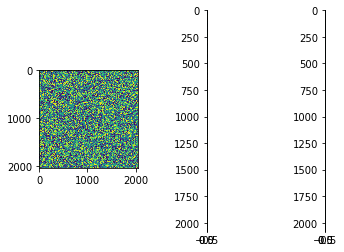

In [50]:
#Size of our test
test_size = (2048, 2048)

#Create test input / output data
a = np.random.random(test_size).astype(np.float32)
b = np.random.random((test_size[1], 1)).astype(np.float32)
with Timer("Function time", logging.INFO) as t:
    c = gpuMatrixVector(a,b)

fig = plt.figure()
plt.subplot(1,3,1)
plt.imshow(a)
plt.subplot(1,3,2)
plt.imshow(b)
plt.subplot(1,3,3)
plt.imshow(c)
fig.show()

In [6]:
#Compute reference using Numpy
c_ref = np.dot(a, b)

#Sum of absolute differences
sad = np.sum(np.abs(c - c_ref))

#Print result
# print("C   = ", c)
# print("Ref = ", c_ref)
print("Sad = ", sad)
print("Per eledment error: " + str(sad / test_size[1]))

Sad =  2.9802322e-08
Per eledment error: 9.934107462565104e-09


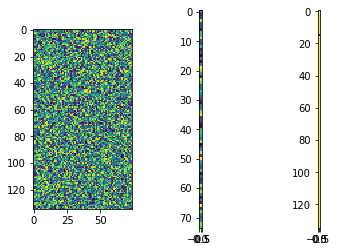

In [7]:
#Size of our test
test_size = (135, 74)

#Create test input / output data
a = np.random.random(test_size).astype(np.float32)
b = np.random.random((test_size[1], 1)).astype(np.float32)
c = np.empty((test_size[0], 1), dtype=np.float32)

fig = plt.figure()
plt.subplot(1,3,1)
plt.imshow(a)
plt.subplot(1,3,2)
plt.imshow(b)
plt.subplot(1,3,3)
plt.imshow(c)
fig.show()

In [11]:
clean_tests()

def test_gpuMatrixVector():
    #Let us test a matrix of 1x1
    a=np.ones((1,1),dtype=np.float32)
    b=2*np.ones((1,1),dtype=np.float32)
    c=gpuMatrixVector(a,b)    
    assert c==pytest.approx(2.0)
    
    #Test that the inner product works
    a=np.ones((1,2),dtype=np.float32)
    b=2*np.ones((2,1),dtype=np.float32)
    c=gpuMatrixVector(a,b)
    assert c==pytest.approx(4.0)
    
    #Test a general matrix
    test_size = (4, 3)
    a = np.random.random(test_size).astype(np.float32)
    b = np.random.random((test_size[1], 1)).astype(np.float32)
    c = gpuMatrixVector(a,b)
    assert c==pytest.approx(a.dot(b))
    
run_pytest(filename='MatrixVectorProductTest.ipynb',pytest_options=['-vvv'])

============================= test session starts ==============================
platform linux -- Python 3.6.6, pytest-3.8.2, py-1.6.0, pluggy-0.7.1 -- /usr/bin/python3
cachedir: .pytest_cache
rootdir: /home/ubuntu/jupyter_notebooks/Alexandros/MilanoGPU2018/notebooks, inifile:
collecting ... collected 1 item

MatrixVectorProductTest.py::test_gpuMatrixVector <- <ipython-input-11-5b39b3a4c81f> PASSED [100%]

=============================== warnings summary ===============================
/home/ubuntu/.local/lib/python3.6/site-packages/ipykernel_launcher.py:26: DeprecationWarning: get() between arrays of different shape is deprecated and will be removed in PyCUDA 2017.x
/home/ubuntu/.local/lib/python3.6/site-packages/ipykernel_launcher.py:26: DeprecationWarning: get() between arrays of different shape is deprecated and will be removed in PyCUDA 2017.x
/home/ubuntu/.local/lib/python3.6/site-packages/ipykernel_launcher.py:26: DeprecationWarning: get() between arrays of different shape is d

0